In [1]:
# =============================
# 1. Install Dependencies (if using Colab)
# =============================

!pip install -q diffusers[training]


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 4.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.2 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.12.0 which is incompatible.

In [15]:
# =============================
# 2. Authentication with Hugging Face Hub
# =============================
from huggingface_hub import notebook_login


 

notebook_login()

In [16]:
# Install Git Large File Storage and configure credentials
!sudo apt -qq install git-lfs
!git config --global credential.helper store

git-lfs is already the newest version (3.0.2-1ubuntu0.3).
0 upgraded, 0 newly installed, 0 to remove and 122 not upgraded.


In [17]:
# =============================
# 3. Training Configuration
# =============================
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size = 128  # Image resolution
    train_batch_size = 16
    eval_batch_size = 16
    num_epochs = 50
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 30
    mixed_precision = "fp16"  # Options: "no" (float32) or "fp16" (mixed)
    output_dir = "ddpm-butterflies-128"

    push_to_hub = True
    hub_model_id = "Docty/butterfiles"  # Replace with your repo ID
    hub_private_repo = None
    overwrite_output_dir = True
    seed = 0

config = TrainingConfig()

Repo card metadata block was not found. Setting CardData to empty.


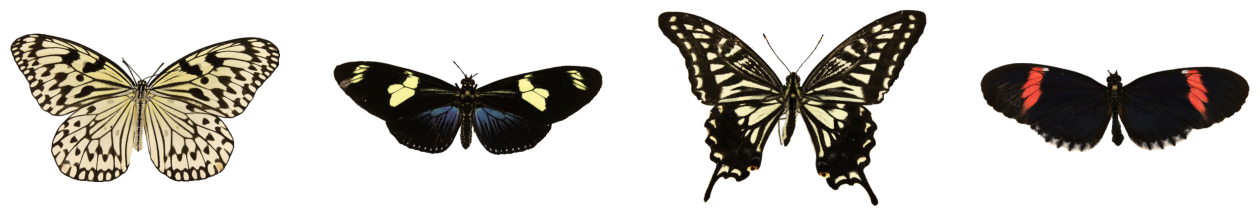

In [18]:
# =============================
# 4. Load and Visualize Dataset
# =============================

from datasets import load_dataset
import matplotlib.pyplot as plt

# Load the butterfly image dataset
config.dataset_name = "huggan/smithsonian_butterflies_subset"
dataset = load_dataset(config.dataset_name, split="train")

# Display sample images
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset[:4]["image"]):
    axs[i].imshow(image)
    axs[i].set_axis_off()
plt.show()

In [19]:
# =============================
# 5. Preprocess Images
# =============================
from torchvision import transforms

# Define image transformations
preprocess = transforms.Compose([
    transforms.Resize((config.image_size, config.image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
])

# Apply transformations to the dataset
def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

dataset.set_transform(transform)

# Create a DataLoader
import torch
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)


In [20]:
# =============================
# 6. Define the UNet Model
# =============================
from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size=config.image_size,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(128, 128, 256, 256, 512, 512),
    down_block_types=("DownBlock2D", "DownBlock2D", "DownBlock2D", "DownBlock2D", "AttnDownBlock2D", "DownBlock2D"),
    up_block_types=("UpBlock2D", "AttnUpBlock2D", "UpBlock2D", "UpBlock2D", "UpBlock2D", "UpBlock2D"),
)

In [21]:
# Test the model's output shape
sample_image = dataset[0]["images"].unsqueeze(0)
print("Input shape:", sample_image.shape)
print("Output shape:", model(sample_image, timestep=0).sample.shape)

Input shape: torch.Size([1, 3, 128, 128])
Output shape: torch.Size([1, 3, 128, 128])


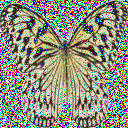

In [22]:
# =============================
# 7. Noise Scheduler & Forward Diffusion Example
# =============================
from diffusers import DDPMScheduler
from PIL import Image

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([50])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

# Visualize noisy image
Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])


In [23]:
# =============================
# 8. Compute Loss for One Batch
# =============================
import torch.nn.functional as F

noise_pred = model(noisy_image, timesteps).sample
loss = F.mse_loss(noise_pred, noise)


In [24]:
# =============================
# 9. Optimizer and Learning Rate Scheduler
# =============================
from diffusers.optimization import get_cosine_schedule_with_warmup

optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

In [25]:
# =============================
# 10.  Evaluation
# =============================
from diffusers import DDPMPipeline
from diffusers.utils import make_image_grid
import os

def evaluate(config, epoch, pipeline):
    images = pipeline(
        batch_size=config.eval_batch_size,
        generator=torch.Generator(device='cpu').manual_seed(config.seed),
    ).images

    image_grid = make_image_grid(images, rows=4, cols=4)
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")


In [26]:
# =============================
# 11. Training Loop
# =============================
from accelerate import Accelerator
from huggingface_hub import create_repo, upload_folder
from tqdm.auto import tqdm
from pathlib import Path

def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "logs"),
    )

    if accelerator.is_main_process:
        if config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        if config.push_to_hub:
            repo_id = create_repo(
                repo_id=config.hub_model_id or Path(config.output_dir).name, exist_ok=True
            ).repo_id
        accelerator.init_trackers("train_example")

    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    global_step = 0

    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch["images"]
            noise = torch.randn(clean_images.shape, device=clean_images.device)
            bs = clean_images.shape[0]
            timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device)

            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            with accelerator.accumulate(model):
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                if accelerator.sync_gradients:
                    accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, pipeline)

            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                if config.push_to_hub:
                    upload_folder(
                        repo_id=repo_id,
                        folder_path=config.output_dir,
                        commit_message=f"Epoch {epoch}",
                        ignore_patterns=["step_*", "epoch_*"],
                    )
                else:
                    pipeline.save_pretrained(config.output_dir)

In [27]:
# =============================
# 12. Launch Training
# =============================
from accelerate import notebook_launcher

args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)
notebook_launcher(train_loop, args, num_processes=1)



Launching training on one GPU.


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0019.png:   0%|          | 0.00/499k [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

0009.png:   0%|          | 0.00/495k [00:00<?, ?B/s]

events.out.tfevents.1744358904.4e734fbf2690.31.0:   0%|          | 0.00/240k [00:00<?, ?B/s]

0029.png:   0%|          | 0.00/538k [00:00<?, ?B/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

events.out.tfevents.1744358904.4e734fbf2690.31.0:   0%|          | 0.00/400k [00:00<?, ?B/s]

0039.png:   0%|          | 0.00/538k [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

0049.png:   0%|          | 0.00/516k [00:00<?, ?B/s]

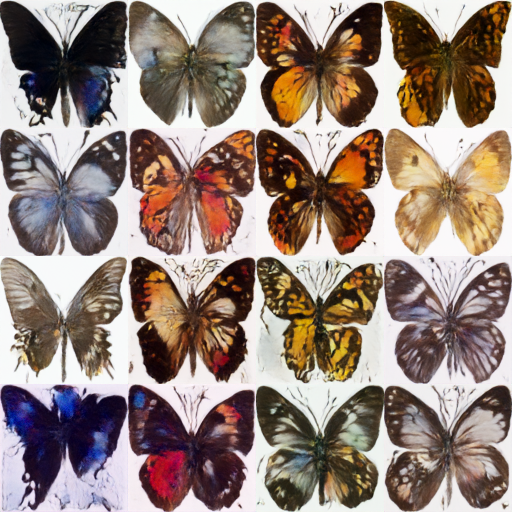

In [28]:
# =============================
# 13. Display Final Sample Image
# =============================
import glob

sample_images = sorted(glob.glob(f"{config.output_dir}/samples/*.png"))
Image.open(sample_images[-1])

In [ ]:
#==================================
#    INFERENCE
#==================================

import torch
from diffusers import UNet2DModel, DDPMScheduler
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Load model and scheduler
device = "cuda" if torch.cuda.is_available() else "cpu"


model.eval()

 
scheduler = DDPMScheduler(
    num_train_timesteps=1000,
    beta_start=0.0001,
    beta_end=0.02,
    beta_schedule="linear"
)

# Sampling parameters
num_images = 4
image_size = 128  # change if needed
channels = 3     # assuming RGB
num_inference_steps = 50

# Start from pure noise
noise = torch.randn((num_images, channels, image_size, image_size)).to(device)
scheduler.set_timesteps(num_inference_steps)

# Denoising loop
with torch.no_grad():
    for t in scheduler.timesteps:
        noise_input = noise
        noise_pred = model(noise_input, t).sample
        noise = scheduler.step(noise_pred, t, noise).prev_sample

# Convert to displayable images
images = (noise.clamp(-1, 1) + 1) / 2  # scale to [0, 1]
grid = make_grid(images.cpu(), nrow=2)

# Show grid
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.imshow(grid.permute(1, 2, 0).numpy())
plt.show()


In [53]:
#===========================================
#             DEPLOY
#==========================================


model.save_pretrained("./my-unet-model" , safe_serialization=False)
scheduler.save_pretrained("./my-unet-model")

In [41]:
%%writefile my-unet-model/model_index.json

{
  "_class_name": "DDPMPipeline",
  "_diffusers_version": "0.26.0",
  "scheduler": ["diffusers", "DDPMScheduler"],
  "unet": ["diffusers", "UNet2DModel"]
}

In [ ]:
from huggingface_hub import upload_folder
upload_folder(folder_path="/kaggle/working/my-unet-model", repo_id=config.hub_model_id)

In [42]:
#model.push_to_hub('Docty/butterfiles')
#scheduler.push_to_hub('Docty/butterfiles')

README.md:   0%|          | 0.00/96.0 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/455M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Docty/butterfiles/commit/8edeca0eedacb163a24fff6b47b58093000eb249', commit_message='Upload model', commit_description='', oid='8edeca0eedacb163a24fff6b47b58093000eb249', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Docty/butterfiles', endpoint='https://huggingface.co', repo_type='model', repo_id='Docty/butterfiles'), pr_revision=None, pr_num=None)

In [ ]:
# !pip install diffusers
from diffusers import DiffusionPipeline, DPMSolverMultistepScheduler
import torch

model_id = config.hub_model_id

# load model and scheduler
pipe = DiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to("cuda" if torch.cuda.is_available() else "cpu")

pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

#pipe.enable_attention_slicing()


In [ ]:
# run pipeline in inference (sample random noise and denoise)
image = pipe(num_inference_steps=30)


image['images'][0]

In [ ]:
#=======================================
# TESTING WITH GRADIO
#===================================

# import gradio as gr
# from diffusers import DDPMPipeline
# import torch

# # Load model
# pipe = DDPMPipeline.from_pretrained(config.hub_model_id)
# pipe.to("cuda" if torch.cuda.is_available() else "cpu")

# # Generation function
# def generate_images(num_images: int = 1, steps: int = 50):
#     output = pipe(num_inference_steps=steps, batch_size=num_images)
#     return output.images

# # Gradio Interface
# gr.Interface(
#     fn=generate_images,
#     inputs=[
#         gr.Slider(1, 8, step=1, label="Number of Images"),
#         gr.Slider(10, 100, step=10, label="Sampling Steps"),
#     ],
#     outputs=gr.Gallery(label="Generated Images"),
#     title="Unconditional Diffusion Generator"
# ).launch()
